# Сегментация изображений

#### 1. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sergeylazarevich","key":"859c9f7c80ea53aad29828f931d9c2e4"}'}

In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

 99% 2.36G/2.38G [01:15<00:00, 58.5MB/s]
100% 2.38G/2.38G [01:16<00:00, 33.6MB/s]


In [5]:
!unzip makeup-lips-segmentation-28k-samples.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: set-lipstick-original/mask/mask00023595.png  
  inflating: set-lipstick-original/mask/mask00023596.png  
  inflating: set-lipstick-original/mask/mask00023597.png  
  inflating: set-lipstick-original/mask/mask00023598.png  
  inflating: set-lipstick-original/mask/mask00023599.png  
  inflating: set-lipstick-original/mask/mask00023600.png  
  inflating: set-lipstick-original/mask/mask00023601.png  
  inflating: set-lipstick-original/mask/mask00023602.png  
  inflating: set-lipstick-original/mask/mask00023603.png  
  inflating: set-lipstick-original/mask/mask00023604.png  
  inflating: set-lipstick-original/mask/mask00023605.png  
  inflating: set-lipstick-original/mask/mask00023606.png  
  inflating: set-lipstick-original/mask/mask00023607.png  
  inflating: set-lipstick-original/mask/mask00023608.png  
  inflating: set-lipstick-original/mask/mask00023609.png  
  inflating: set-lipstick-original/mask/mask000

In [6]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path

In [7]:
DATASET_FILEPATH = Path('./set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

Нужно удалить лишние файлы

In [8]:
label_arr = []
for dirname, _, filenames in os.walk(MASKS_FILEPATH):
    for filename in filenames:
        label_arr.append(filename)

data = pd.read_csv(LIST_CSV_FILEPATH)
data = data[['filename', 'mask']]
data.drop(data.loc[~data[MASKS].isin(label_arr)].index, inplace=True)
data.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


### 2. И затем обучить Модель на выбор из segmentation_models_pytorch

In [10]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.5 MB/s 
     |████████████████████████████████| 376 kB 25.9 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b8fbd9c102fc65c08f21a933ec67039e091859f553d1a8a40e9f4d82b83b4d11
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5b2cc1d113aa887257f2ed4ee6b1e182868e4589b9282ab1f0a6dcd2ed1a6604
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [31]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from torchsummary import summary
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Создадим класс для кастомного датасета:

In [21]:
IMG_SIZE = 256

class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        # loading data
        self.data = data
        # images paths array 
        self.image_arr = self.data['filename']
        # masks paths array
        self.label_arr = self.data['mask']
        # lenth of pairs
        self.data_len = len(self.data)
        
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        
        img = cv2.cvtColor(cv2.imread(os.path.join(IMAGES_FILEPATH, self.image_arr[index])), cv2.COLOR_BGR2RGB)       
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / (IMG_SIZE-1)
        img = img.permute(2,0,1)
        
        # loading masks
        mask = cv2.imread(os.path.join(MASKS_FILEPATH, self.label_arr[index]))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = np.asarray(mask).astype('float')           
        mask = torch.as_tensor(mask) / (IMG_SIZE-1)  
        mask = mask.permute(2,0,1)
            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

Посмотрим что получилось.

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


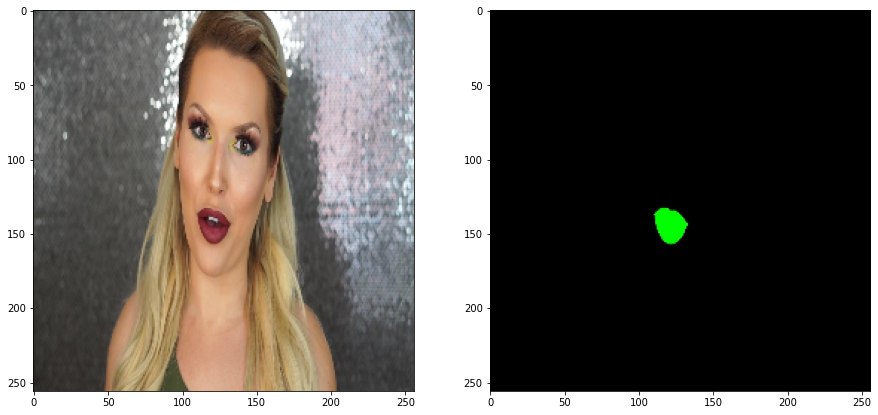

In [23]:
IMG_SIZE = 256

dataset = LipsDataset(data)
img, masks = dataset[157]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

Делим на train и test

In [72]:
# 70 % в тренировочную выборку, 30 - в тестовую
train, test = train_test_split(data, test_size=0.3, random_state=42)

# Упорядочиваем индексацию
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.shape, test.shape

((19978, 2), (8562, 2))

Создадим модель

In [33]:
BACKBONE = 'resnet34'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Оборачиваем каждую выборку в наш кастомный датасет:

In [74]:
train_dataset = LipsDataset(train, preprocessing=preprocess_input)
test_dataset = LipsDataset(test, preprocessing=preprocess_input)

train_data_loader = DataLoader(
                                train_dataset,
                                batch_size=8,
                                shuffle=True
                            )

test_data_loader = DataLoader(
                                test_dataset,
                                batch_size=4,
                                shuffle=False
                            )

Определим метрики

In [34]:
criterion = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.0001)

In [76]:
train_epoch = smp.utils.train.TrainEpoch(
                                        segmodel, 
                                        loss=criterion, 
                                        metrics=metrics,
                                        optimizer=optimizer,
                                        device=device,
                                        verbose=True
                                    )

test_epoch = smp.utils.train.ValidEpoch(
                                        segmodel, 
                                        loss=criterion, 
                                        metrics=metrics,
                                        device=device,
                                        verbose=True
                                    )

Тренируем модель

In [77]:
max_score = 0

for i in range(1, 4):
    print(f'Epoch: {i}')
    train_logs = train_epoch.run(train_data_loader)
    test_logs = test_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < test_logs['iou_score']:
        max_score = test_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [04:29<00:00,  7.95it/s, dice_loss - 0.03684, iou_score - 0.9412]
Model saved!
Epoch: 2
valid: 100%|██████████| 2141/2141 [04:23<00:00,  8.12it/s, dice_loss - 0.02899, iou_score - 0.9473]
Model saved!
Epoch: 3
valid: 100%|██████████| 2141/2141 [04:21<00:00,  8.18it/s, dice_loss - 0.02711, iou_score - 0.9494]
Model saved!


In [78]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

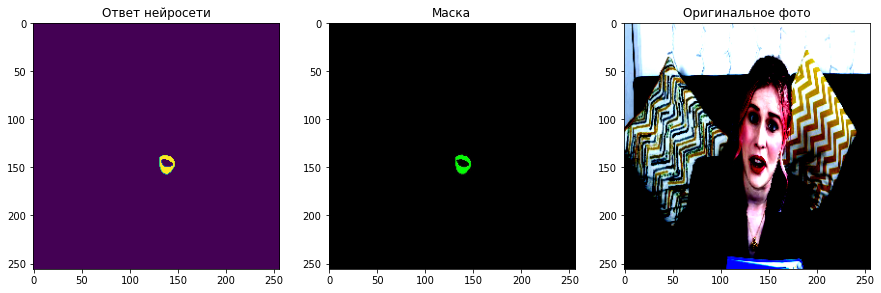

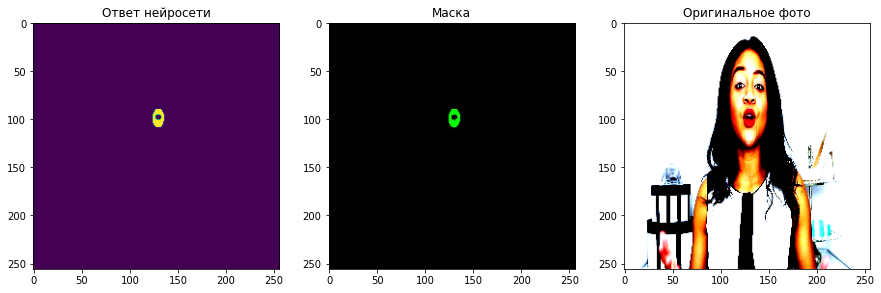

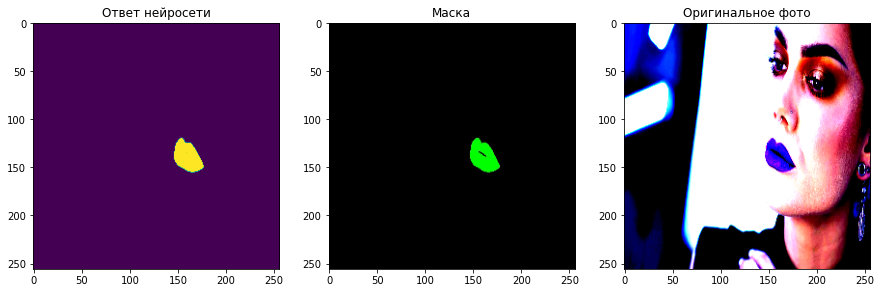

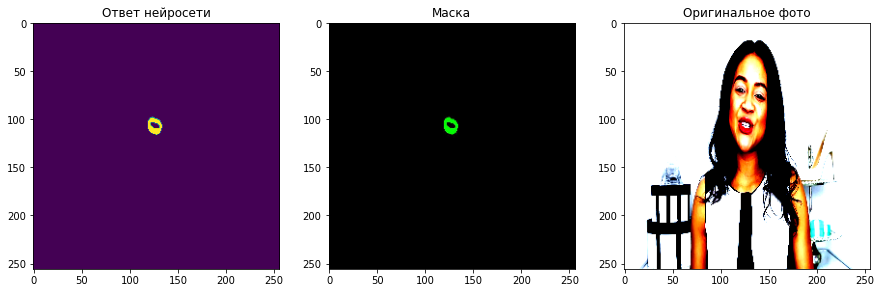

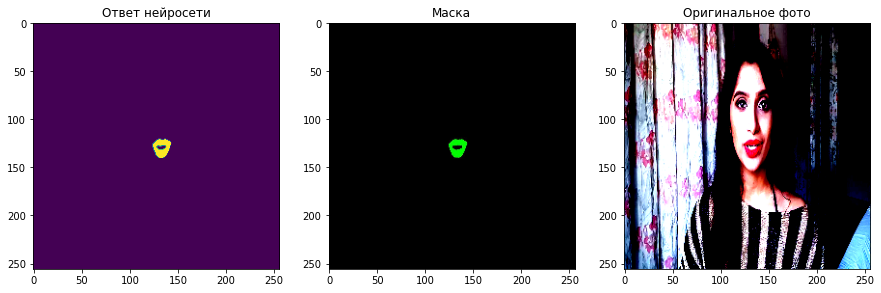

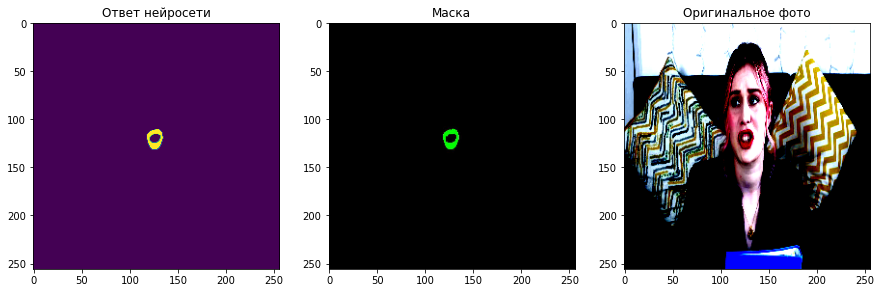

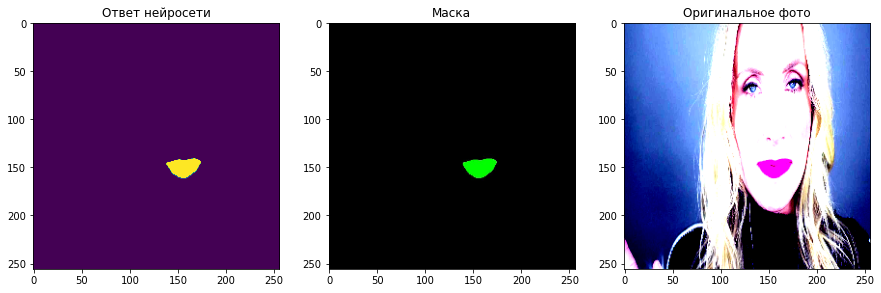

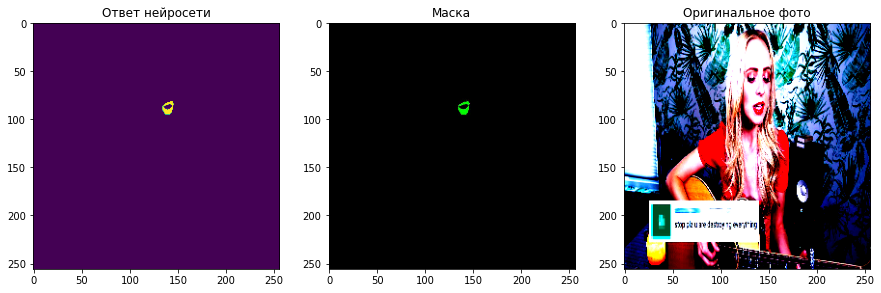

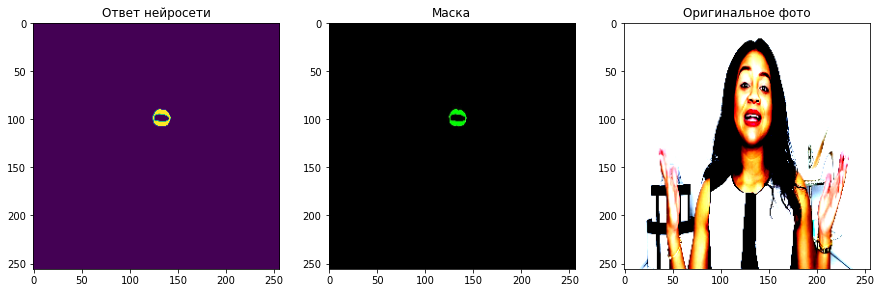

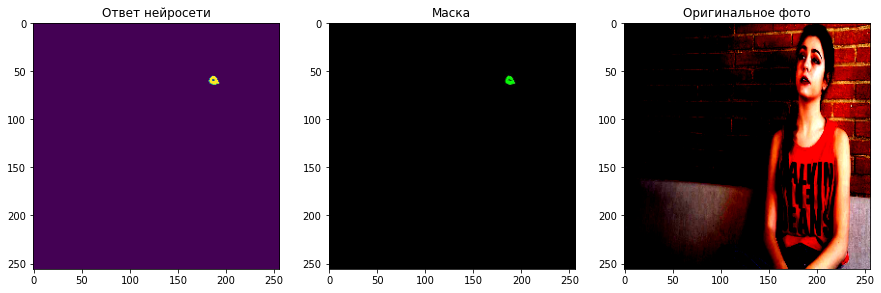

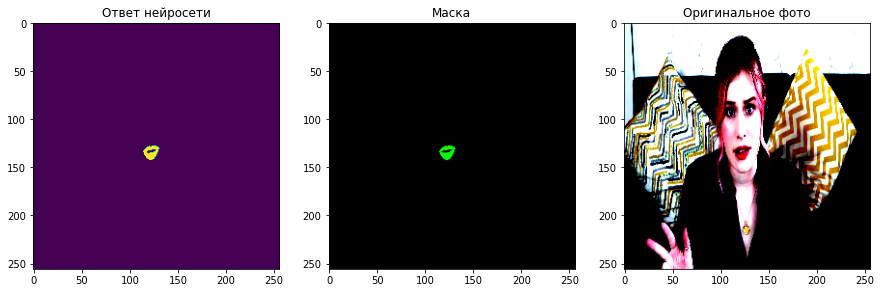

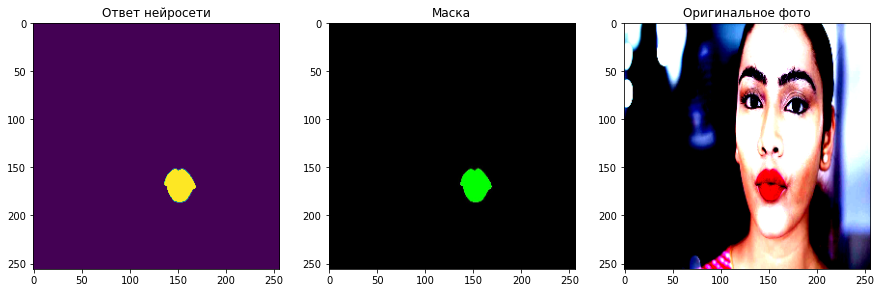

In [80]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    segmodel.eval()
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Ответ нейросети')
        axarr[1].imshow(labels.squeeze().detach().cpu().numpy()[j,:, :].transpose(1,2,0))
        axarr[1].set_title('Маска')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Оригинальное фото')
        plt.show()
    
    if i > 10:
        break